In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [14]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [16]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [17]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [18]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

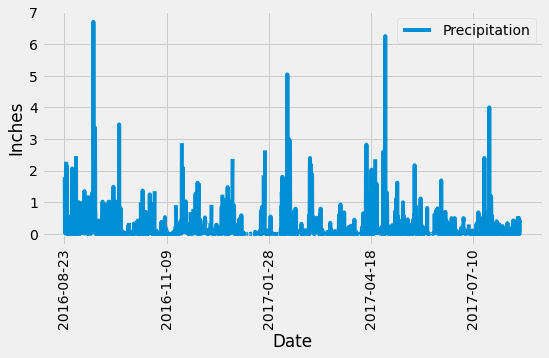

In [79]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# Calculate the date one year from the last date in data set. 
#  try this to pass for year ago instead of manually entering date.  datetime.datetime.strptime('24052010', "%d%m%Y").date()
year_ago = dt.date(2017, 8, 23) - dt.timedelta(366)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
data = pd.DataFrame(precip, columns=['date', 'prcp'])
data.set_index('date', inplace=True)

# Sort the dataframe by date
sorted_data = data.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
sorted_data.plot(figsize=(8,4))
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["Precipitation"], loc='upper right')
plt.xticks(rotation='vertical')
plt.show()

In [80]:
sorted_data.head(-5)

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-21,0.02
2017-08-21,0.00
2017-08-21,NaN


In [64]:
len(sorted_data)

2223

In [82]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_data.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [83]:
# Design a query to calculate the total number stations in the dataset
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [96]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.prcp).count(Measurement.prcp).group_by(Measurement.station).all()

TypeError: count() takes 1 positional argument but 2 were given

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()